In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite

In [3]:
SN_Array = composite.grab("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN", multi_epoch = False, make_corr = False)

4975 Total Spectra found
777 spectra of SNe with host reddening corrections
Arrays cleaned


In [4]:
SN_attributes = dir(SN_Array[0])   
SN_metadata = {}
for a in SN_attributes:
    if '__' not in a:
        SN_metadata[a] = 0
for m in SN_metadata:
    for SN in SN_Array:
        if getattr(SN, m) is not None:
            SN_metadata[m] = SN_metadata[m] + 1

ignore_keys = ['minwave','maxwave', 'light_curves', 'ivar', 'name', 'flux', 'interp', 'wavelength', 'filename', 'ref',
               'up_conf', 'low_conf', 'spec_bin', 'source', 'morph', 'phase_array', 'red_array', 'dm15_array', 'velocity',
               'phase', 'x1', 'x2', 'vel', 'csp_light_curves']
k=0
for i, m in enumerate(SN_metadata):
    if m not in ignore_keys and not m.startswith('e_') and 'err' not in m:
        k+=1
        print k,m, SN_metadata[m]

1 logMst_lc 96
2 cov_mb_s_lc 96
3 mu_mlcs31 166
4 glon_host 98
5 zCMB_mlcs31 166
6 av_mlcs17 170
7 cov_s_c_lc 96
8 m_b_cfa 120
9 dm15_from_fits 97
10 b_minus_v_cfa 120
11 c_salt 116
12 ned_host 525
13 SNR 777
14 czCMB_host 98
15 mtype_host 98
16 filt_host 98
17 x1_salt2 150
18 cz_host 98
19 mu_salt 116
20 sep 98
21 Ebv_host 98
22 mb_lc 96
23 Bmag_salt2 150
24 ra 236
25 delta_mlcs17 170
26 bias_lc 96
27 av_25 314
28 hubble_res 149
29 glat_host 98
30 carbon 193
31 Bmag_salt 116
32 t1_host 98
33 ypos_host 98
34 zCMB_salt2 150
35 zCMB_salt 116
36 redshift 773
37 c_lc 96
38 av_mlcs31 175
39 zCMB_lc 96
40 czLG_host 98
41 dec 236
42 zhel_lc 96
43 s_salt 116
44 x1_lc 96
45 zCMB_mlcs17 170
46 c_salt2 150
47 tmax_lc 96
48 dm15_source 274
49 mu_mlcs17 170
50 na 72
51 morph_array 777
52 delta_mlcs31 166
53 cov_mb_c_lc 96
54 mjd 645
55 xpos_host 98
56 mu_salt2 150
57 v_at_max 290


In [5]:
SN_Array = composite.grab("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN", multi_epoch = True, make_corr = False)

4975 Total Spectra found
4975 spectra of SNe with host reddening corrections
Arrays cleaned


In [6]:
event_dict = {}
for i in range(len(SN_Array)):
    if event_dict.get(SN_Array[i].name) is None:
        event_dict[SN_Array[i].name] = [SN_Array[i]]
    else:
        event_dict[SN_Array[i].name] = event_dict.get(SN_Array[i].name) + [SN_Array[i]]

In [7]:
event_dict_corr = {}
SN_Array_corr = []
for i in range(len(SN_Array)):
    if SN_Array[i].phase != None:
        SN_Array_corr.append(SN_Array[i])
print len(SN_Array_corr)

len_before = len(SN_Array_corr)
SN_Array_corr = composite.remove_peculiars(SN_Array_corr,'../data/info_files/pec_Ias.txt')
print len_before - len(SN_Array_corr), 'Peculiar Ias removed', len(SN_Array_corr), 'spectra left'
SN_Array_corr = composite.check_host_corrections(SN_Array_corr)
for i in range(len(SN_Array_corr)):
    if event_dict_corr.get(SN_Array_corr[i].name) is None:
        event_dict_corr[SN_Array_corr[i].name] = [SN_Array_corr[i]]
    else:
        event_dict_corr[SN_Array_corr[i].name] = event_dict_corr.get(SN_Array_corr[i].name) + [SN_Array_corr[i]]

4225
103 Peculiar Ias removed 4122 spectra left


In [8]:
%matplotlib inline

In [9]:
spec_per_sn = []
dm15_dist = []
phase_dist = []
morph_dist = []
no_dm = []
no_morph = []
for SN in event_dict.keys():
    spec_per_sn.append(len(event_dict[SN]))
    if event_dict[SN][0].dm15_source != None:
        dm15_dist.append(event_dict[SN][0].dm15_source)
    elif event_dict[SN][0].dm15_from_fits != None:
        dm15_dist.append(event_dict[SN][0].dm15_from_fits)
    else:
        no_dm.append(event_dict[SN][0])
#     if event_dict[SN][0].morph != None and event_dict[SN][0].morph > 0:
#         morph_dist.append(event_dict[SN][0].morph)
#     else:
#         no_morph.append(event_dict[SN][0])
    if event_dict[SN][0].ned_host != None:
        morph_dist.append(event_dict[SN][0].ned_host)
    else:
        no_morph.append(event_dict[SN][0])

    for spec in event_dict[SN]:
        if spec.phase != None:
            phase_dist.append(spec.phase)

In [10]:
spec_per_sn_corr = []
dm15_dist_corr = []
phase_dist_corr = []
morph_dist_corr = []
no_dm_corr = []
no_morph_corr = []
red_dist_corr = []
av_dist = []
num_spec = 0
for SN in event_dict_corr.keys():
    spec_per_sn_corr.append(len(event_dict_corr[SN]))
    if len(event_dict_corr[SN]) >= 40:
        print SN, len(event_dict_corr[SN])
    if event_dict_corr[SN][0].dm15_source != None:
        dm15_dist_corr.append(event_dict_corr[SN][0].dm15_source)
    elif event_dict_corr[SN][0].dm15_from_fits != None:
        dm15_dist_corr.append(event_dict_corr[SN][0].dm15_from_fits)
    else:
        no_dm_corr.append(event_dict_corr[SN][0])
    if event_dict_corr[SN][0].ned_host != None and event_dict_corr[SN][0].ned_host > 0:
        morph_dist_corr.append(event_dict_corr[SN][0].ned_host)
    else:
        no_morph_corr.append(event_dict_corr[SN][0])
    
    if event_dict[SN][0].av_25 != None:
        if event_dict[SN][0].av_25 > 3.:
            print SN, event_dict[SN][0].av_25
        av_dist.append(event_dict[SN][0].av_25)
    elif event_dict[SN][0].av_mlcs31 != None:
        if event_dict[SN][0].av_mlcs31 > 3.:
            print SN, event_dict[SN][0].av_mlcs31
        av_dist.append(event_dict[SN][0].av_mlcs31)
    elif event_dict[SN][0].av_mlcs17 != None:
        if event_dict[SN][0].av_mlcs17 > 3.:
            print SN, event_dict[SN][0].av_mlcs17
        av_dist.append(event_dict[SN][0].av_mlcs17)
        
    if event_dict[SN][0].redshift != None:
        if event_dict[SN][0].redshift > .12:
            print SN, event_dict[SN][0].redshift
        red_dist_corr.append(event_dict[SN][0].redshift)
    
    for spec in event_dict_corr[SN]:
        num_spec+=1
        if spec.phase != None:
            phase_dist_corr.append(spec.phase)
print num_spec

1994d 77
1998bu 42
2011fe 43
2005cf 83
2003cg 43
2003du 82
2007le 58
2006x 79
2006x 3.3384
2007af 52
2002bo 61
2001v 44
1996ai 3.811
1996ab 0.13
3485


In [11]:
print len(event_dict.keys())
print len(event_dict_corr.keys())
print len(no_dm)
print len(no_dm_corr)
print len(no_morph)
print len(morph_dist_corr)
print len(no_morph_corr)

777
305
406
0
252
239
66


In [12]:
for SN in no_morph_corr:
    print SN.name

2004as
2002eu
2006eq
2006en
2003hu
1993ac
2005lz
2007s
2001fh
2007al
2000fa
2006h
2007n
2005ls
2005al
2005ag
2007cq
2008bf
2006gt
2006oa
2006py
2004gu
2006nz
2004l
2002g
2006mp
2006fw
1996c
2006lu
2005hj
2008bc
1990y
2008c
2006is
2005ew
2000cf
2005ku
2006ak
2003ae
1996bl
2007if
2003kc
2006bw
2002hu
2005hf
2005hc
2007co
2002kf
2006td
2006te
2003iv
2005eu
2006d
2006cj
2006n
2001c
2007qe
2007jg
2005bg
2005be
2009f
2006al
2006bu
2006bz
2007cp
1996ab


In [13]:
print np.median(dm15_dist_corr)
print np.mean(dm15_dist_corr)
print np.std(dm15_dist_corr)
print np.sort(dm15_dist_corr)

1.12
1.20042025283
0.283092115708
[ 0.68        0.71        0.74        0.77        0.78        0.8         0.8
  0.80421351  0.81        0.81        0.82        0.84        0.84        0.85
  0.85        0.85210952  0.85210952  0.86        0.87        0.87        0.87
  0.8704156   0.8719093   0.88        0.88        0.88        0.88        0.88
  0.89        0.89        0.89        0.89        0.89854105  0.9
  0.9083046   0.919       0.92        0.92        0.92        0.92
  0.92192579  0.92447046  0.93        0.93        0.93883481  0.94        0.94
  0.94        0.94        0.94        0.9401483   0.94242142  0.94359963
  0.95        0.95811882  0.96        0.96        0.96        0.97
  0.9792529   0.97930081  0.98        0.98        0.98        0.98        0.98
  0.98795596  0.99        0.99        0.9978077   1.          1.          1.
  1.          1.00035851  1.00130645  1.00293004  1.00366615  1.0072203
  1.00821962  1.01        1.01        1.02        1.02142208  1.0254657

In [14]:
print np.median(red_dist_corr)
print np.sort(red_dist_corr)

0.0197785
[ 0.000804    0.00146     0.001825    0.002058    0.002128    0.002425
  0.002843    0.002992    0.003       0.003156    0.003392    0.003395
  0.003559    0.003699    0.00389     0.003896    0.00413     0.00424
  0.004266    0.00475     0.00488     0.00489     0.0051      0.00514
  0.00524     0.00529     0.005457    0.005464    0.005477    0.005664
  0.005791    0.005871    0.005871    0.005961    0.006031    0.006211
  0.006261    0.006384    0.006461    0.00649449  0.0065      0.006535
  0.006561    0.006665    0.006721    0.006878    0.006945    0.007125
  0.007235    0.007318    0.007388    0.007575    0.007609    0.007679
  0.007899    0.008312    0.008569    0.0086      0.00877     0.00888948
  0.008969    0.00921     0.009346    0.009393    0.0094      0.00948
  0.0095      0.01012     0.010344    0.010404    0.010431    0.010567
  0.010847    0.010941    0.011415    0.011575    0.011639    0.012175
  0.012372    0.012402    0.012549    0.012695    0.01287891  0.0129

[  1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.  23.  25.  27.  29.
  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.  51.  53.  55.  57.  59.
  61.  63.  65.  67.  69.  71.  73.  75.  77.  79.  81.  83.  85.  87.  89.
  91.]
[2, 77, 14, 14, 2, 14, 5, 10, 26, 1, 15, 5, 19, 2, 3, 8, 5, 8, 12, 32, 8, 2, 30, 10, 5, 14, 7, 5, 3, 1, 3, 12, 7, 6, 19, 4, 3, 7, 9, 18, 7, 23, 9, 7, 13, 3, 9, 7, 33, 23, 6, 10, 2, 4, 12, 10, 2, 1, 21, 8, 13, 13, 17, 12, 14, 17, 3, 11, 2, 10, 6, 2, 5, 7, 32, 1, 4, 5, 9, 19, 7, 20, 3, 8, 1, 28, 9, 17, 7, 4, 42, 1, 2, 5, 11, 3, 13, 4, 13, 3, 16, 8, 6, 6, 6, 1, 8, 31, 10, 3, 16, 20, 29, 1, 8, 5, 35, 23, 23, 19, 1, 4, 10, 2, 2, 5, 3, 4, 12, 21, 4, 4, 43, 9, 26, 5, 2, 1, 8, 13, 9, 1, 12, 3, 8, 6, 9, 5, 83, 11, 1, 43, 27, 13, 16, 19, 2, 5, 6, 9, 3, 7, 4, 12, 6, 12, 15, 24, 3, 6, 1, 12, 30, 32, 11, 16, 8, 14, 13, 28, 2, 15, 1, 82, 5, 4, 32, 1, 13, 23, 8, 20, 4, 3, 38, 14, 13, 8, 12, 1, 6, 11, 58, 15, 15, 25, 8, 5, 10, 15, 3, 4, 7, 6, 2, 6, 7, 11, 7, 32, 11, 24, 

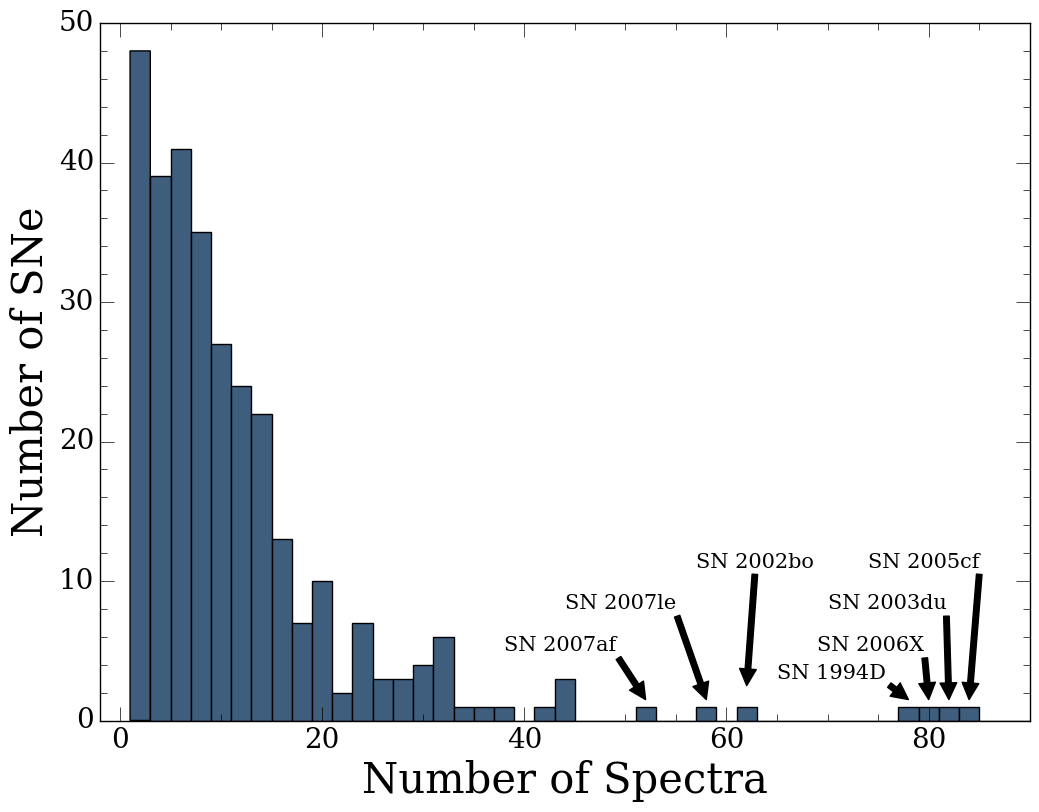

In [17]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("Number of Spectra", fontsize = 30)  
plt.xlim([0,65])
plt.ylabel("Number of SNe", fontsize = 30)  
# plt.hist(spec_per_sn, bins = 50, color="seagreen",log = True)
bins = np.linspace(1,91,num = 46, retstep=True)[0]
print bins
print spec_per_sn_corr
plt.hist(spec_per_sn_corr, bins = bins, color='#3F5D7D')
plt.xlim([-2, 90])
plt.ylim([0, 50])
plt.gca().annotate('SN 2007af', xy=(52, 1.5), xytext=(38, 5),
            arrowprops=dict(facecolor='black'), fontsize=15)
plt.gca().annotate('SN 2007le', xy=(58, 1.5), xytext=(44, 8),
            arrowprops=dict(facecolor='black'), fontsize=15)
plt.gca().annotate('SN 2002bo', xy=(62, 2.5), xytext=(57, 11),
            arrowprops=dict(facecolor='black'), fontsize=15)
plt.gca().annotate('SN 1994D', xy=(78, 1.5), xytext=(65, 3),
            arrowprops=dict(facecolor='black'), fontsize=15)
plt.gca().annotate('SN 2003du', xy=(82, 1.5), xytext=(70, 8),
            arrowprops=dict(facecolor='black'), fontsize=15)
plt.gca().annotate('SN 2005cf', xy=(84, 1.5), xytext=(74, 11),
            arrowprops=dict(facecolor='black'), fontsize=15)
plt.gca().annotate('SN 2006X', xy=(80, 1.5), xytext=(69, 5),
            arrowprops=dict(facecolor='black'), fontsize=15)
plt.savefig('../../../Paper_Drafts/demographics_updated/spec_per_sn.pdf', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../../../Talks/spec_per_sn.png', dpi = 300, bbox_inches = 'tight')
# 1994d 77
# 2005cf 83
# 2003cg 43
# 2003du 82
# 2007le 58
# 2006x 79
# 2007af 52
# 2002bo 61
plt.show()

[ 0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15  1.2
  1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75  1.8
  1.85  1.9   1.95  2.    2.05  2.1   2.15  2.2 ]


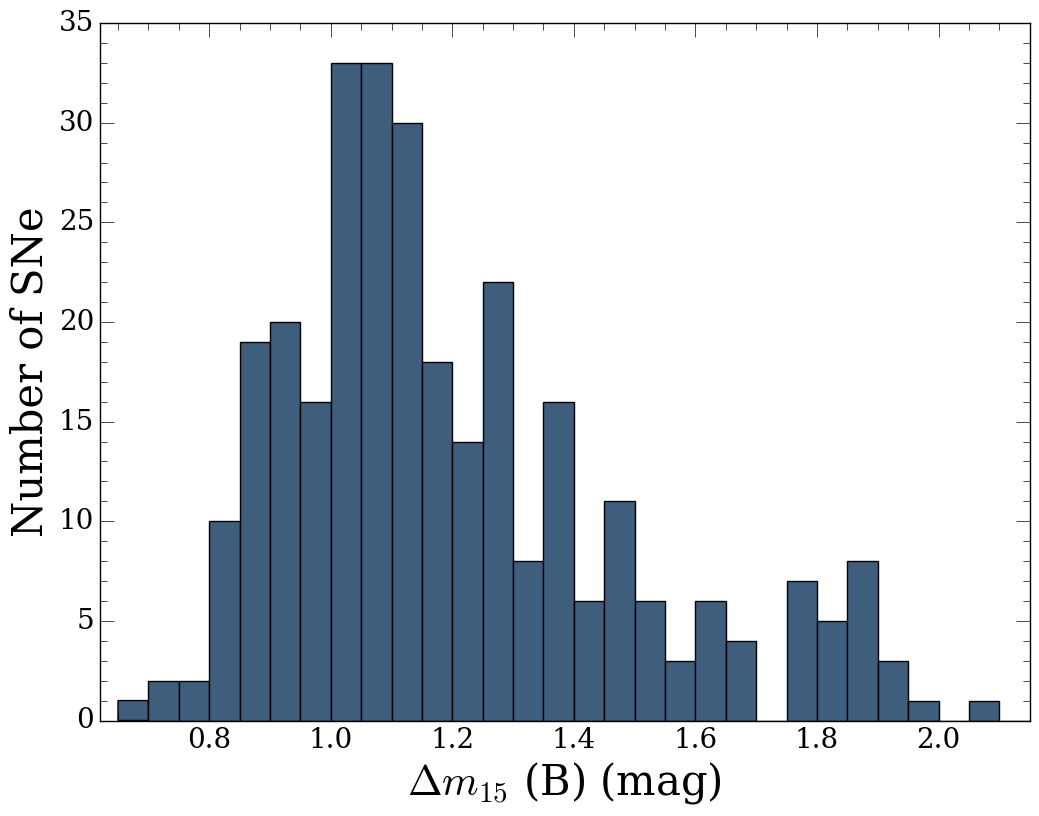

In [15]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("$\Delta m_{15}$ (B) (mag)", fontsize=30)  
plt.ylabel("Number of SNe", fontsize=30)  
# plt.hist(dm15_dist, bins = 40, color="seagreen")
bins = np.linspace(.65, 2.2,num = 32, retstep=True)[0]
print bins
plt.hist(dm15_dist_corr, bins = bins, color='#3F5D7D')
plt.xlim([.62,2.15])
plt.savefig('../../../Paper_Drafts/demographics_updated/dm15_dist.pdf', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../../../Talks/dm15_dist.png', dpi = 300, bbox_inches = 'tight')
plt.show()

239
[4.0, 8.0, 8.0, 14.0, 8.0, 13.0, 14.0, 8.0, 12.0, 8.0, 14.0, 8.0, 15.0, 9.0, 13.0, 11.0, 15.0, 3.0, 10.0, 19.0, 10.0, 17.0, 13.0, 12.0, 1.0, 12.0, 8.0, 1.0, 10.0, 19.0, 19.0, 19.0, 1.0, 8.0, 12.0, 8.0, 12.0, 6.0, 19.0, 15.0, 19.0, 11.0, 8.0, 14.0, 8.0, 19.0, 15.0, 19.0, 14.0, 12.0, 11.0, 10.0, 19.0, 15.0, 1.0, 8.0, 8.0, 10.0, 14.0, 10.0, 1.0, 19.0, 4.0, 12.0, 14.0, 12.0, 15.0, 19.0, 1.0, 15.0, 11.0, 13.0, 13.0, 8.0, 10.0, 13.0, 13.0, 13.0, 8.0, 8.0, 12.0, 12.0, 19.0, 12.0, 1.0, 19.0, 10.0, 13.0, 8.0, 8.0, 14.0, 15.0, 19.0, 8.0, 14.0, 12.0, 13.0, 19.0, 12.0, 10.0, 19.0, 14.0, 8.0, 15.0, 8.0, 19.0, 3.0, 1.0, 13.0, 1.0, 13.0, 12.0, 13.0, 11.0, 8.0, 1.0, 3.0, 14.0, 8.0, 10.0, 14.0, 8.0, 12.0, 19.0, 14.0, 14.0, 12.0, 15.0, 15.0, 13.0, 12.0, 19.0, 11.0, 19.0, 11.0, 10.0, 12.0, 11.0, 16.0, 10.0, 4.0, 13.0, 12.0, 1.0, 17.0, 15.0, 14.0, 12.0, 15.0, 14.0, 1.0, 9.0, 14.0, 14.0, 18.0, 13.0, 9.0, 19.0, 10.0, 13.0, 14.0, 12.0, 19.0, 10.0, 8.0, 10.0, 8.0, 13.0, 8.0, 13.0, 15.0, 15.0, 1.0, 2.0, 11

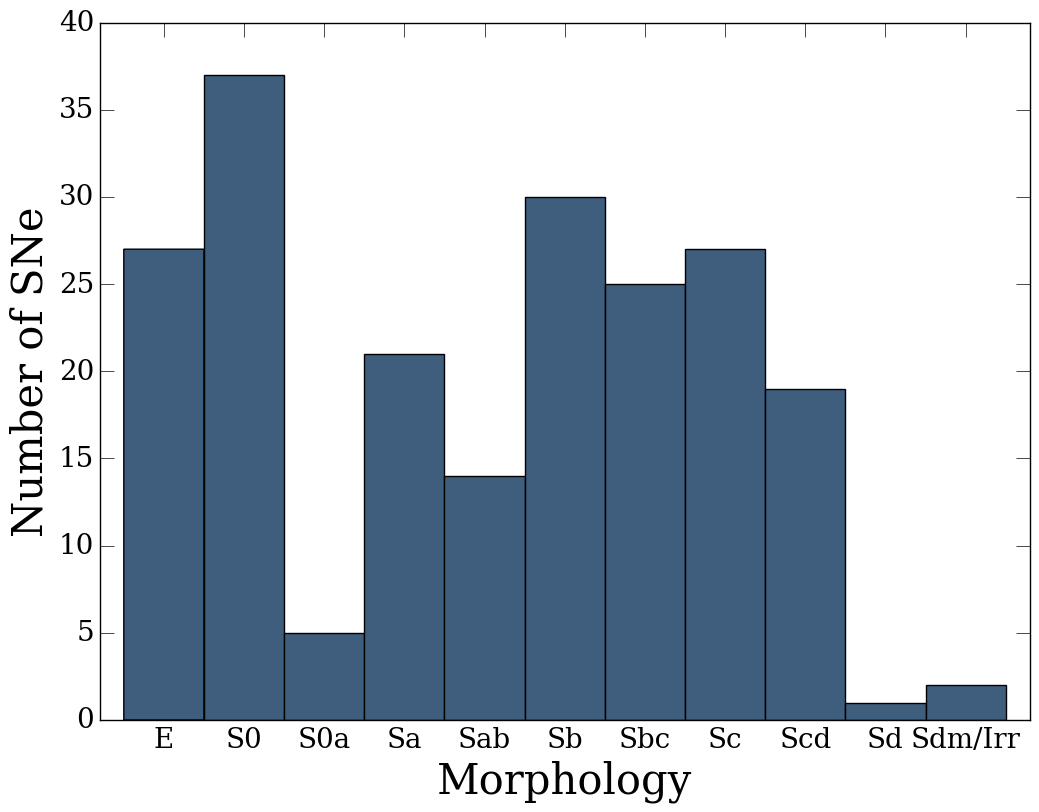

In [21]:
new_morph_dist_corr = []
print len(morph_dist_corr)
print morph_dist_corr
for num in morph_dist_corr:
    if num <= 7:
        new_morph_dist_corr.append(1)
    else:
        new_morph_dist_corr.append(num-6)
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
x = [1,2,3,4,5,6,7,8,9,10,11]
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
labels = ['E','E/S0','S0','S0a','Sa','Sab','Sb','Sbc','Sc','Scd','Sd/Irr']
labels = ['E','S0','S0a','Sa','Sab','Sb','Sbc','Sc','Scd','Sd', 'Sdm/Irr']
plt.xticks(x, labels, fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)

plt.xlabel("Morphology", fontsize=30)  
plt.ylabel("Number of SNe", fontsize=30)  
plt.ylim([0,40])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.tick_params(
    which='minor', 
    bottom='off', 
    top='off',
    left='off',
    right='off',
    length=5)
# plt.hist(morph_dist,bins=[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5],  color="seagreen")
plt.hist(new_morph_dist_corr,bins=[.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5],  color='#3F5D7D')
plt.xlim([.2,11.8])
plt.savefig('../../../Paper_Drafts/demographics_updated/morph_dist.pdf', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../../../Talks/morph_dist.png', dpi = 300, bbox_inches = 'tight')
plt.show()

[ -20.  -10.    0.   10.   20.   30.   40.   50.   60.   70.   80.   90.
  100.  110.  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.
  220.  230.  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.
  340.  350.  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.
  460.  470.  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.
  580.  590.  600.  610.  620.  630.  640.]


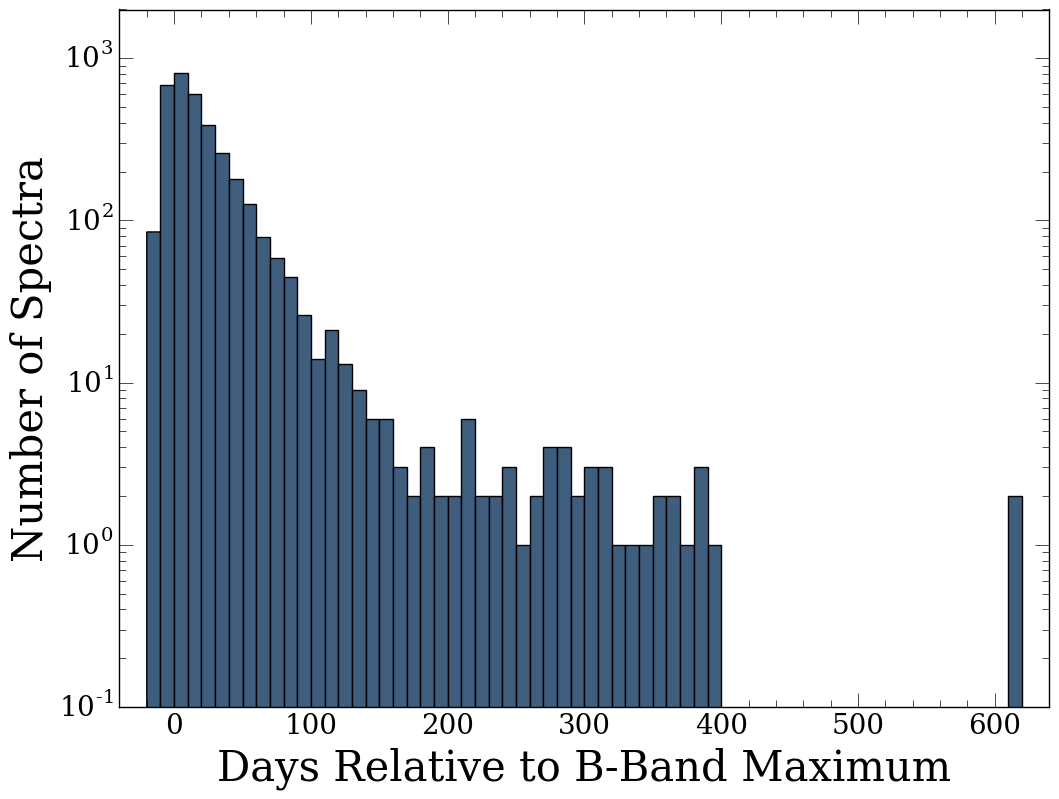

In [22]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlim([-40,650])
plt.ylim([10**-1,2.*10**3.])
# plt.ylim([0,800])
plt.ylabel("Number of Spectra", fontsize=30)  
plt.xlabel("Days Relative to B-Band Maximum", fontsize=30)  
# plt.hist(phase_dist, bins = 70, color="seagreen", log = True)
bins = np.linspace(-20,640,num = 67, retstep=True)[0]
print bins
plt.hist(phase_dist_corr, bins = bins, color='#3F5D7D', log=True)
plt.xlim([-40,640])
plt.savefig('../../../Paper_Drafts/demographics_updated/phase_dist.pdf', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../../../Talks/phase_dist.png', dpi = 300, bbox_inches = 'tight')
plt.show()

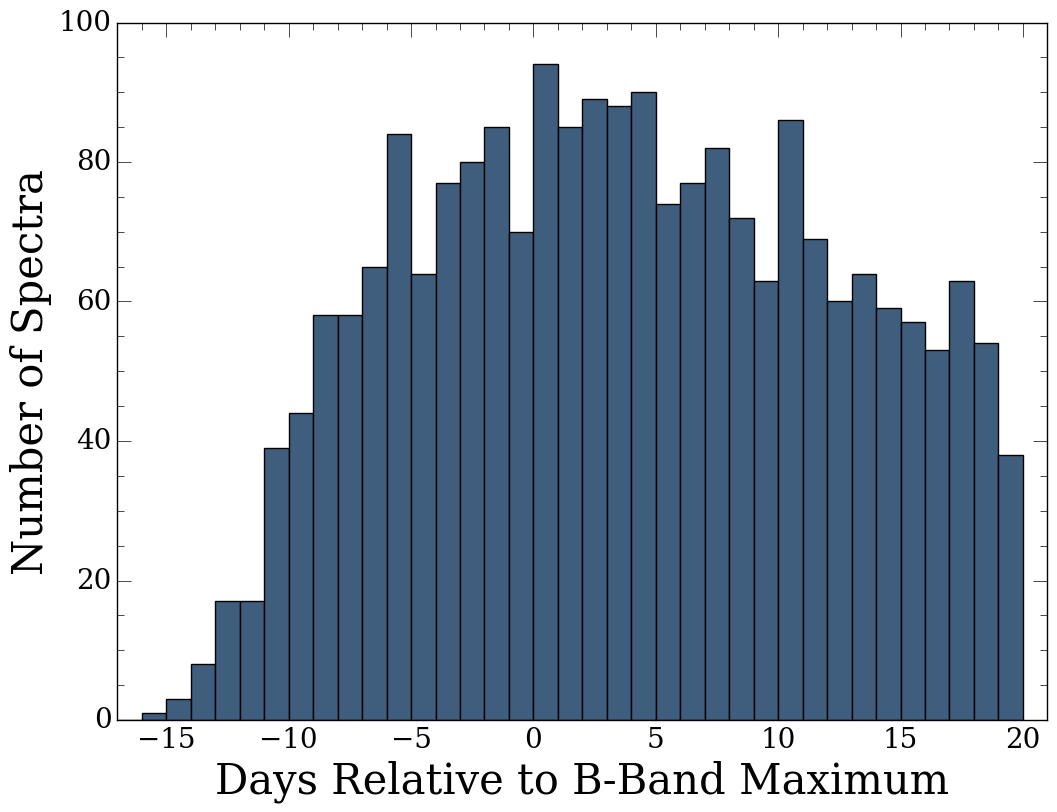

In [23]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlim([-17,21])
plt.xlabel("Days Relative to B-Band Maximum", fontsize=30)  
plt.ylabel("Number of Spectra", fontsize=30)  
# plt.hist(phase_dist, bins = 70, color="seagreen", log = True)
plt.hist(phase_dist_corr,bins=range(-20, 20 + 1, 1), color='#3F5D7D')
plt.savefig('../../../Paper_Drafts/demographics_updated/phase_dist_early.pdf', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../../../Talks/phase_dist_early.png', dpi = 300, bbox_inches = 'tight')
plt.show()

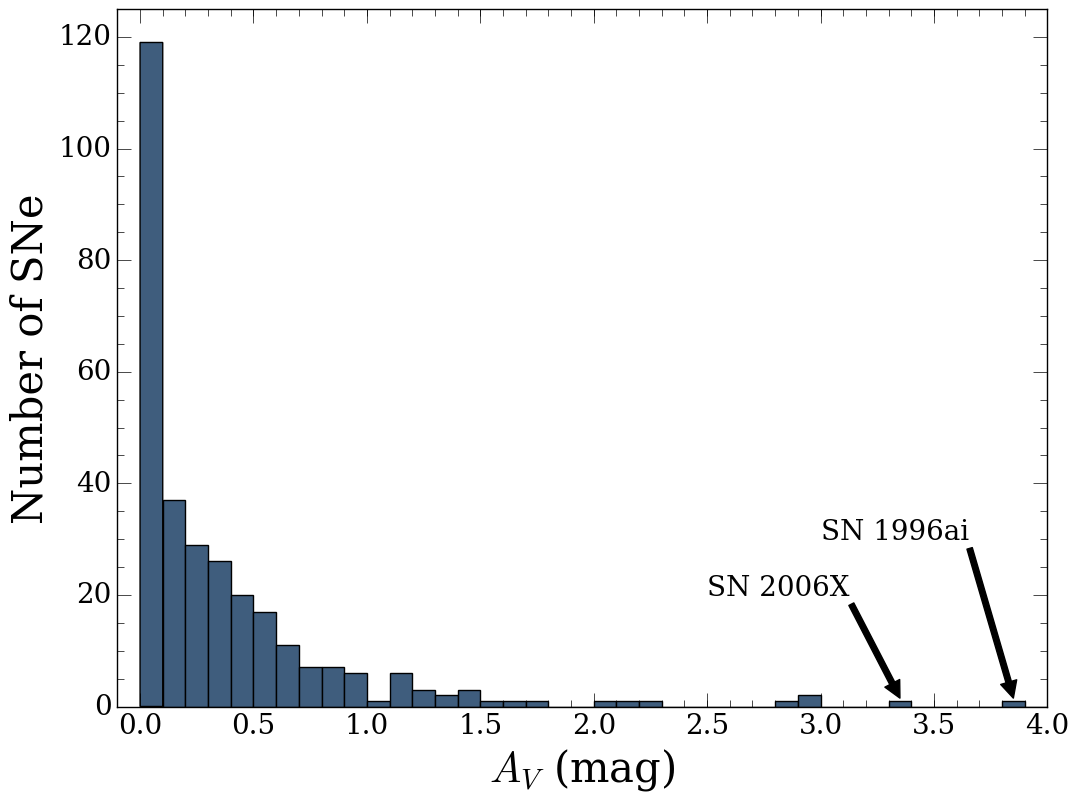

In [30]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("$A_{V}$ (mag)", fontsize=30)  
plt.ylabel("Number of SNe", fontsize=30)
bins = np.linspace(0.,4.,num=41,retstep = True)[0]
plt.xlim([-.1,4.])
plt.ylim([0,125])
plt.hist(av_dist,bins=bins,  color='#3F5D7D')
plt.gca().annotate('SN 2006X', xy=(3.35, 1.5), xytext=(2.5, 20),
            arrowprops=dict(facecolor='black'), fontsize=20)
plt.gca().annotate('SN 1996ai', xy=(3.85, 1.5), xytext=(3., 30),
            arrowprops=dict(facecolor='black'), fontsize=20)
plt.savefig('../../../Paper_Drafts/demographics_updated/av_dist.pdf', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../../../Talks/av_dist.png', dpi = 300, bbox_inches = 'tight')
plt.show()

[ 0.     0.005  0.01   0.015  0.02   0.025  0.03   0.035  0.04   0.045
  0.05   0.055  0.06   0.065  0.07   0.075  0.08   0.085  0.09   0.095  0.1
  0.105  0.11   0.115  0.12   0.125  0.13   0.135  0.14 ]


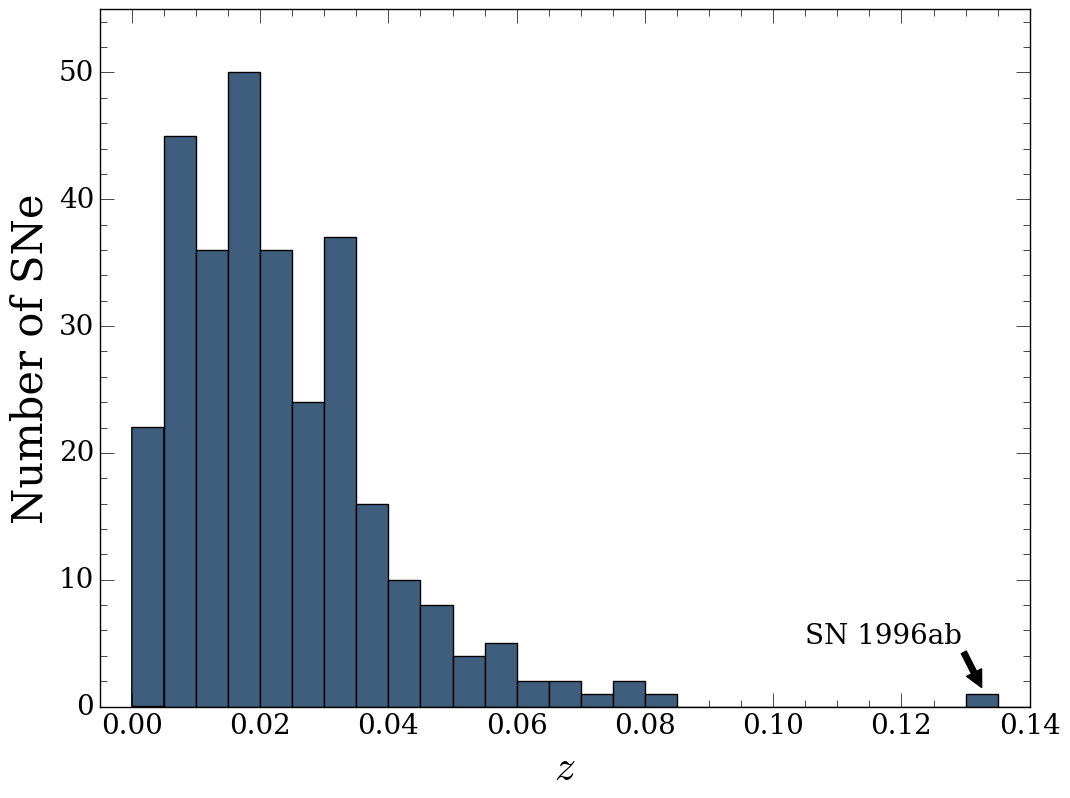

In [31]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=5)

plt.xlabel("$z$", fontsize=30)  
plt.ylabel("Number of SNe", fontsize=30)
bins = np.linspace(0.,.14,num=29,retstep = True)[0]
print bins
plt.hist(red_dist_corr,bins=bins,  color='#3F5D7D')
plt.xlim([-.005,.14])
plt.ylim([0.,55])
plt.gca().annotate('SN 1996ab', xy=(.1325, 1.5), xytext=(.105, 5),
            arrowprops=dict(facecolor='black'), fontsize=20)
plt.savefig('../../../Paper_Drafts/demographics_updated/red_dist.pdf', dpi = 300, bbox_inches = 'tight')
# plt.savefig('../../../Talks/red_dist.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [15]:
bsnip,cfa,csp,uv,other = 0, 0, 0, 0, 0
for SN in SN_Array:
    if SN.source == 'bsnip':
        bsnip += 1
    elif SN.source == 'cfa':
        cfa += 1
    elif SN.source == 'csp':
        csp += 1
    elif SN.source == 'uv' or SN.source == 'swift_uv' or SN.source == 'foley_hst':
        uv +=1
    else:
        other += 1

In [16]:
print 'bsnip:', bsnip
print 'cfa:', cfa
print 'csp:', csp
print 'uv:', uv
print 'other:', other

bsnip: 1273
cfa: 2584
csp: 616
uv: 195
other: 307


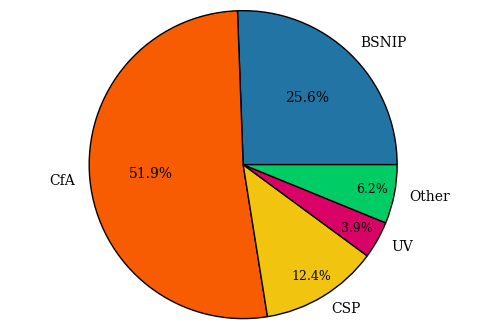

In [17]:
labels = 'BSNIP', 'CfA', 'CSP', 'UV', 'Other'
sizes = [bsnip, cfa, csp, uv, other]
colors = ['#2274A5', '#f75c03', '#f1c40f', '#d90368', '#00cc66']
plt.rc('font', family='serif')
ax = plt.subplot(111) 
wedges, titles, texts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors)
# for w in wedges:
#     w.set_linewidth(1)
#     w.set_edgecolor('white')
for i, txt in enumerate(texts):
    if i>=2:
        ang = (wedges[i].theta2 + wedges[i].theta1) / 2.
        x = wedges[i].r * 0.85 * np.cos(ang*np.pi/180)
        y = wedges[i].r * 0.85 * np.sin(ang*np.pi/180)
        txt.set_position((x,y))
        txt.set_fontsize(9)
plt.axis('equal')
# plt.rcParams['patch.linewidth'] = 0
# plt.rcParams['patch.edgecolor'] = 'white' 
# plt.savefig('../../../Paper_Drafts/demographics_updated/sources.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [18]:
bsnip,cfa,csp,uv,other = 0, 0, 0, 0, 0
for SN in event_dict.keys():
    sources = []
    for spectrum in event_dict[SN]:
        sources.append(spectrum.source)
    sources = set(sources)
    for s in sources:
        if s == 'bsnip':
            bsnip += 1
        elif s == 'cfa':
            cfa += 1
        elif s == 'csp':
            csp += 1
        elif s == 'uv' or s == 'swift_uv' or s == 'foley_hst':
            uv +=1
        else:
            other += 1

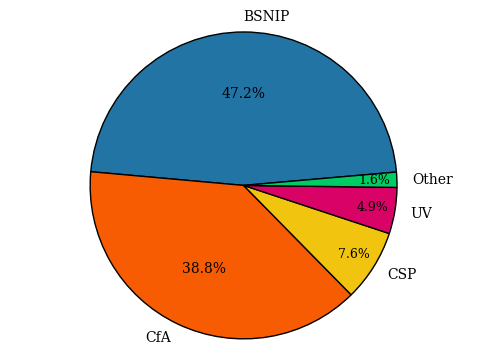

In [19]:
labels = 'BSNIP', 'CfA', 'CSP', 'UV', 'Other'
sizes = [bsnip, cfa, csp, uv, other]
colors = ['#2274A5', '#f75c03', '#f1c40f', '#d90368', '#00cc66']
plt.rc('font', family='serif')
ax = plt.subplot(111) 
wedges, titles, texts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors, startangle =5)
# for w in wedges:
#     w.set_linewidth(1)
#     w.set_edgecolor('white')
for i, txt in enumerate(texts):
    if i>=2:
        ang = (wedges[i].theta2 + wedges[i].theta1) / 2.
        x = wedges[i].r * 0.85 * np.cos(ang*np.pi/180)
        y = wedges[i].r * 0.85 * np.sin(ang*np.pi/180)
        txt.set_position((x,y))
        txt.set_fontsize(9)
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'white' 
plt.axis('equal')
# plt.savefig('../../../Paper_Drafts/demographics_updated/event_sources.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [20]:
specific_sn_arr = composite.grab("SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where Spectra.SN = '2005a'", multi_epoch = True, make_corr = False)

8 Total Spectra found
8 spectra of SNe with host reddening corrections
Arrays cleaned


In [21]:
for SN in specific_sn_arr:
    print SN.filename, SN.av_25, SN.source, SN.phase

sn2005a-20050115.357-br.flm 2.9711 bsnip 8.32695515651
sn2005A-20050108.13-fast.flm 2.9711 cfa 1.23540378765
sn2005A-20050110.11-ldss2.flm 2.9711 cfa 3.17829457364
sn2005A-20050111.04-ldss2.flm 2.9711 cfa 4.09086448828
SN05A_050114_b01_P20_DB.dat 2.9711 csp 7.1033264644
SN05A_050114_r01_P20_DB.dat 2.9711 csp 7.1033264644
SN05A_050204_b01_DUP_WF.dat 2.9711 csp 27.6901187321
SN05A_050212_b01_DUP_WF.dat 2.9711 csp 35.5401825138


In [22]:
print event_dict.keys()

[u'2004ab', u'1996bo', u'1996bl', u'1996bk', u'1996bv', u'1996bt', u'2012dn', u'2003gj', u'2004gz', u'1996by', u'2004s', u'2008fp', u'2004p', u'2004w', u'2004y', u'2007gk', u'2007gi', u'2008fg', u'2004e', u'2008fj', u'2004j', u'2004h', u'2007ge', u'2007hu', u'2016fff', u'snf20080522-000', u'1993aj', u'1993ai', u'1993ae', u'1993ac', u'1993ab', u'2005lz', u'2005ls', u'2005lu', u'2005lt', u'2006dt', u'2006dh', u'2006di', u'2006do', u'2006dm', u'2006da', u'2006dd', u'2003eh', u'2003ek', u'1998bn', u'2006os', u'2006or', u'2006oq', u'2004at', u'2006ou', u'2006ot', u'2003ez', u'2004az', u'2003ep', u'1998bp', u'2006oa', u'1998bu', u'2001cp', u'2006nz', u'2008bw', u'2001cg', u'2006r', u'2001cj', u'2001ck', u'2002fi', u'2002fk', u'1997e', u'1999aa', u'2002fb', u'2007ux', u'2006dw', u'2006nr', u'1997t', u'1999aq', u'1997y', u'2016eiy', u'2007cb', u'2000dp', u'2000dr', u'2006lu', u'2000dx', u'2000dd', u'2000df', u'2000dg', u'2009ag', u'2009ad', u'2000dl', u'2000dm', u'2000dn', u'2009an', u'2000dk'

In [23]:
import matplotlib.ticker as ticker

In [24]:
wave_min = 1000
wave_max = 12000
dw = 2
wavelength = np.arange(wave_min, wave_max,
                           dtype=int, step=dw)
source_dict = {"cfa":np.zeros(len(wavelength)), "bsnip":np.zeros(len(wavelength)), "csp":np.zeros(len(wavelength)), 
               "uv":np.zeros(len(wavelength)), "other":np.zeros(len(wavelength))}
print len(SN_Array)
for SN in SN_Array:
    w1 = SN.minwave
    w2 = SN.maxwave
    wrange = np.where((wavelength >= w1) & (wavelength <= w2))
    if SN.source == "uv" or SN.source == "swift_uv" or SN.source == "foley_hst":
        source_dict["uv"][wrange] = source_dict["uv"][wrange] + 1
    else:
        source_dict[SN.source][wrange] = source_dict[SN.source][wrange] + 1

4975


In [25]:
# plt.figure(figsize=(12, 9)) 
# plt.rc('font', family='serif')
# ax = plt.subplot(111)
# plt.minorticks_on()
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)
# plt.tick_params(
#     which='major', 
#     bottom='on', 
#     top='on',
#     left='on',
#     right='on',
#     length=10)
# plt.tick_params(
#     which='minor', 
#     bottom='on', 
#     top='on',
#     left='on',
#     right='on',
#     length=5)

# colors = {'bsnip':'#2274A5', 'cfa':'#f75c03', 'csp':'#f1c40f', 'uv':'#d90368', 'other':'#00cc66'}
# labels = {'bsnip':'BSNIP', 'cfa':'CfA', 'csp':'CSP', 'uv':'UV', 'other':'Other'}
# plt.xlabel('Rest Wavelength ' + "($\mathrm{\AA}$)", fontsize=30)  
# plt.ylabel("Number of Spectra", fontsize=30)
# for s in source_dict:
#     plt.plot(wavelength, source_dict[s], color = colors[s], linewidth=3, label=labels[s])
# plt.xlim([1000,12000])

# handles, lbs = plt.gca().get_legend_handles_labels()
# handles = [handles[4], handles[1], handles[3], handles[2], handles[0]]
# lbs = [lbs[4], lbs[1], lbs[3], lbs[2], lbs[0]]
# plt.legend(handles,lbs,loc=1)

# plt.savefig('../../../Paper_Drafts/demographics_updated/wave_sources.pdf', dpi = 300, bbox_inches = 'tight')
# plt.show()

In [26]:
total = sum(source_dict.values())
for s in source_dict:
    source_dict[s] = source_dict[s]/total

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


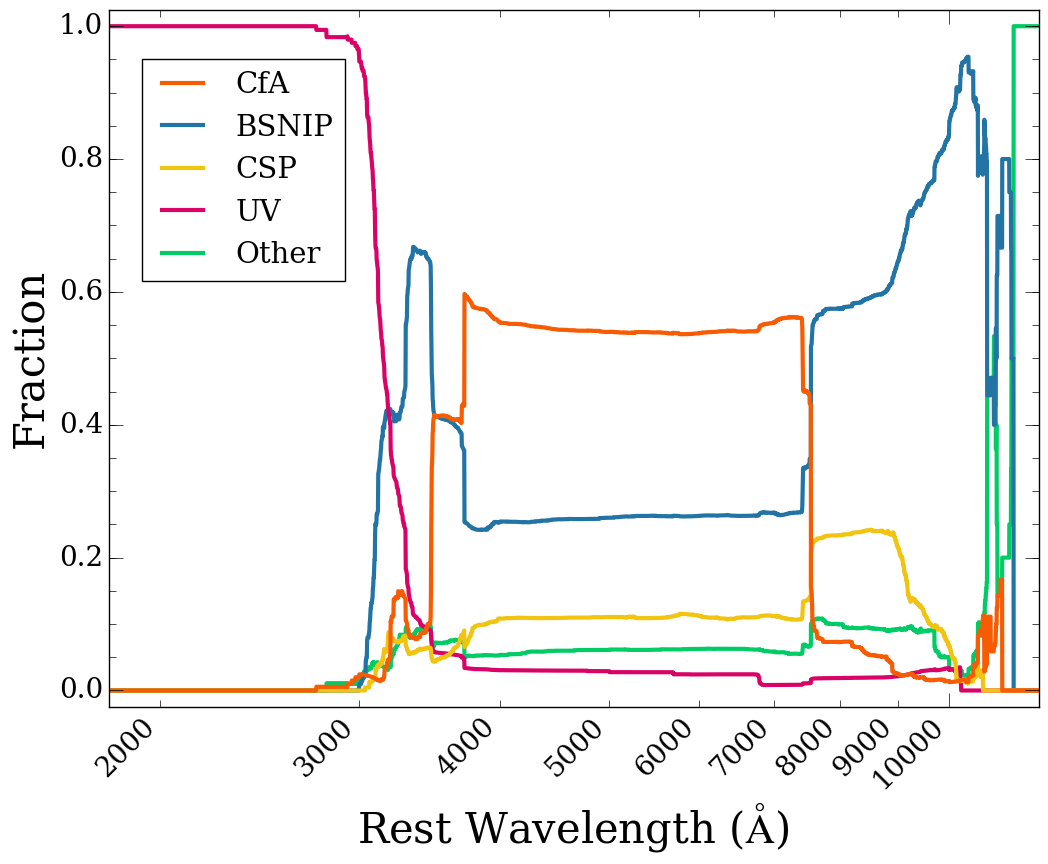

In [28]:
plt.figure(figsize=(12, 9)) 
plt.rc('font', family='serif')
ax = plt.subplot(111)


colors = {'bsnip':'#2274A5', 'cfa':'#f75c03', 'csp':'#f1c40f', 'uv':'#d90368', 'other':'#00cc66'}
labels = {'bsnip':'BSNIP', 'cfa':'CfA', 'csp':'CSP', 'uv':'UV', 'other':'Other'}
plt.xlabel('Rest Wavelength ' + "($\mathrm{\AA}$)", fontsize=30)  
plt.ylabel("Fraction", fontsize=30)
for s in source_dict:
    plt.semilogx(wavelength, source_dict[s], color = colors[s], linewidth=3, label=labels[s])
plt.xlim([1800,12000])

handles, lbs = plt.gca().get_legend_handles_labels()
handles = [handles[4], handles[1], handles[3], handles[2], handles[0]]
lbs = [lbs[4], lbs[1], lbs[3], lbs[2], lbs[0]]
leg = plt.legend(handles,lbs,loc=2, fontsize=21, bbox_to_anchor=(0.02, 0.45, 0.48, 0.5))
leg.get_frame().set_linewidth(1.0)

ax.xaxis.set_minor_formatter(ticker.LogFormatter(labelOnlyBase=False))
ax.xaxis.set_major_formatter(ticker.LogFormatter())
plt.minorticks_on()
plt.yticks(fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10,
    labelsize=20)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    labelbottom='on',
    length=5,
    labelsize=20)
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=45, ha="right" )
plt.setp(plt.gca().xaxis.get_minorticklabels(), rotation=45, ha="right" )
plt.ylim(-.025, 1.025)
plt.savefig('../../../Paper_Drafts/demographics_updated/wave_sources_frac.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()